<a href="https://colab.research.google.com/github/WanQi-K/DataSciencePortfolio/blob/main/28_Flight_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

# Import necessary libraries
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up Kaggle API credentials securely
os.environ['KAGGLE_USERNAME'] = "WanQi83"  # Ensure this is correct
os.environ['KAGGLE_KEY'] = "your_kaggle_api_key"  # Replace with your actual key

# Initialize and authenticate Kaggle API
api = KaggleApi()
api.authenticate()

# Download the correct dataset (IBM HR Analytics Attrition dataset)
dataset_name = 'shubhambathwal/flight-price-prediction'
api.dataset_download_files(dataset_name, path='./', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

In [ ]:
df = pd.read_csv('Clean_Dataset.csv')
df = df.drop(['Unnamed: 0', 'flight'], axis=1)

# New feature: Route
df['route'] = df['source_city'] + '_' + df['destination_city']

# New feature: Days left buckets
bins = [0, 2, 7, 30, df['days_left'].max()]
labels = ['1-2', '3-7', '8-30', '30+']
df['days_left_bucket'] = pd.cut(df['days_left'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
# New feature: Categorize actual duration (in hours)
print("\nDuration (hours) Stats:")
print(df['duration'].describe())
print("NaNs in Duration:", df['duration'].isna().sum())
print("Sample Duration with Routes:")
print(df[['source_city', 'destination_city', 'duration']].head(10))

# Define duration buckets (in hours)
duration_bins = [0, 2, 4, 50]  # <2hrs, 2-4hrs, >4hrs (max ~49.83 hours)
duration_labels = ['short', 'medium', 'long']
print("Duration Bins (Hours):", duration_bins)

# Categorize duration
df['duration_bucket'] = pd.cut(df['duration'], bins=duration_bins, labels=duration_labels, include_lowest=True)


Duration (hours) Stats:
count    300153.000000
mean         12.221021
std           7.191997
min           0.830000
25%           6.830000
50%          11.250000
75%          16.170000
max          49.830000
Name: duration, dtype: float64
NaNs in Duration: 0
Sample Duration with Routes:
  source_city destination_city  duration
0       Delhi           Mumbai      2.17
1       Delhi           Mumbai      2.33
2       Delhi           Mumbai      2.17
3       Delhi           Mumbai      2.25
4       Delhi           Mumbai      2.33
5       Delhi           Mumbai      2.33
6       Delhi           Mumbai      2.08
7       Delhi           Mumbai      2.17
8       Delhi           Mumbai      2.17
9       Delhi           Mumbai      2.25
Duration Bins (Hours): [0, 2, 4, 50]


In [ ]:
df

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,route,days_left_bucket,duration_bucket
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,Delhi_Mumbai,1-2,medium
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,Delhi_Mumbai,1-2,medium
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,Delhi_Mumbai,1-2,medium
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,Delhi_Mumbai,1-2,medium
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,Delhi_Mumbai,1-2,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265,Chennai_Hyderabad,30+,long
300149,Vistara,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105,Chennai_Hyderabad,30+,long
300150,Vistara,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099,Chennai_Hyderabad,30+,long
300151,Vistara,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585,Chennai_Hyderabad,30+,long


In [ ]:
# One-hot encoding
one_hot_cols = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'stops', 'class', 'route', 'days_left_bucket', 'duration_bucket']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[one_hot_cols])
encoded_cols = encoder.get_feature_names_out(one_hot_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, dtype=int)

df_processed = pd.concat([df[['days_left', 'duration', 'price']], encoded_df], axis=1)
scaler = StandardScaler()
df_processed[['days_left', 'duration']] = scaler.fit_transform(df_processed[['days_left', 'duration']])

In [ ]:
df_processed

,days_left,duration,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,route_Mumbai_Delhi,route_Mumbai_Hyderabad,route_Mumbai_Kolkata,days_left_bucket_1-2,days_left_bucket_3-7,days_left_bucket_30+,days_left_bucket_8-30,duration_bucket_long,duration_bucket_medium,duration_bucket_short
0,-1.843875,-1.397531,5953,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,-1.843875,-1.375284,5953,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,-1.843875,-1.397531,5956,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-1.843875,-1.386407,5955,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
4,-1.843875,-1.375284,5955,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300148,1.695692,-0.297695,69265,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
300149,1.695692,-0.250421,77105,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
300150,1.695692,0.223718,79099,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
300151,1.695692,-0.308819,81585,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
# a) Does price vary with airlines?
airline_prices = {col.replace('airline_', ''): df_processed[df_processed[col] == 1]['price'].mean()
                  for col in [c for c in df_processed.columns if c.startswith('airline_')]}
print("\nQa: Average Price by Airline (INR):")
for airline, price in sorted(airline_prices.items(), key=lambda x: x[1]):
    print(f"{airline}: {price:.0f}")


Qa: Average Price by Airline (INR):
AirAsia: 4091
Indigo: 5324
GO_FIRST: 5652
SpiceJet: 6179
Air_India: 23507
Vistara: 30397


In [ ]:
# b) How is price affected 1-2 days before departure?

days_left_bucket_1to2 = df_processed[df_processed['days_left_bucket_1-2'] == 1]['price'].mean()
days_left_bucket_3to7 = df_processed[df_processed['days_left_bucket_3-7'] == 1]['price'].mean()
days_left_bucket_8to30 = df_processed[df_processed['days_left_bucket_8-30'] == 1]['price'].mean()
days_left_bucket_30plus = df_processed[df_processed['days_left_bucket_30+'] == 1]['price'].mean()

print(f"\nQb: Avg Price 1-2 Days Before: {days_left_bucket_1to2:.0f} INR")
print(f"\nQb: Avg Price 3-7 Days Before: {days_left_bucket_3to7:.0f} INR")
print(f"\nQb: Avg Price 8-30 Days Before: {days_left_bucket_8to30:.0f} INR")
print(f"\nQb: Avg Price 30+ Days Before: {days_left_bucket_30plus:.0f} INR")
print(f"\nPrice Increase: {((days_left_bucket_1to2 - days_left_bucket_30plus) / days_left_bucket_30plus * 100):.1f}%")


Qb: Avg Price 1-2 Days Before: 27421 INR

Qb: Avg Price 3-7 Days Before: 26231 INR

Qb: Avg Price 8-30 Days Before: 21023 INR

Qb: Avg Price 30+ Days Before: 19261 INR

Price Increase: 42.4%


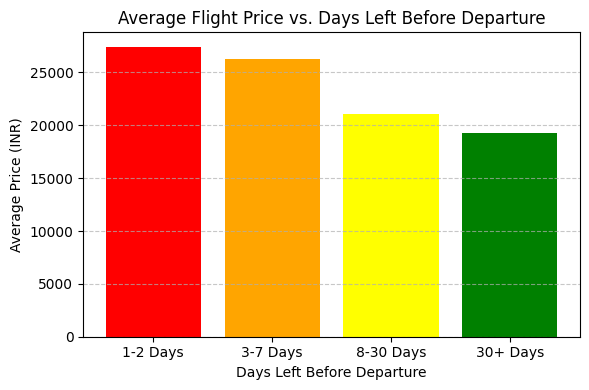

In [ ]:
import matplotlib.pyplot as plt

# Data for the bar graph
days_left_buckets = ['1-2 Days', '3-7 Days', '8-30 Days', '30+ Days']
avg_prices = [days_left_bucket_1to2, days_left_bucket_3to7, days_left_bucket_8to30, days_left_bucket_30plus]

# Create the bar graph
plt.figure(figsize=(6, 4))
plt.bar(days_left_buckets, avg_prices, color=['red', 'orange', 'yellow', 'green'])
plt.xlabel("Days Left Before Departure")
plt.ylabel("Average Price (INR)")
plt.title("Average Flight Price vs. Days Left Before Departure")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# c) Does ticket price change with departure/arrival time?
dep_time_prices = {col.replace('departure_time_', ''): df_processed[df_processed[col] == 1]['price'].mean()
                   for col in [c for c in df_processed.columns if c.startswith('departure_time_')]}
print("\nQc: Avg Price by Departure Time (INR):")
for time, price in sorted(dep_time_prices.items(), key=lambda x: x[1]):
    print(f"{time}: {price:.0f}")


Qc: Avg Price by Departure Time (INR):
Late_Night: 9295
Afternoon: 18179
Early_Morning: 20371
Evening: 21232
Morning: 21631
Night: 23062


In [ ]:
# d) How does price change with source/destination?
route_prices = df.groupby('route')['price'].mean().sort_values()
print("\nQd: Avg Price by Route (INR) - Top 5 Cheapest:")
print(route_prices.head(5))
print("Top 5 Priciest:")
print(route_prices.tail(5))


Qd: Avg Price by Route (INR) - Top 5 Cheapest:
route
Hyderabad_Delhi    17243.945685
Delhi_Hyderabad    17347.288379
Bangalore_Delhi    17723.313972
Delhi_Bangalore    17880.216315
Mumbai_Delhi       18725.320008
Name: price, dtype: float64
Top 5 Priciest:
route
Mumbai_Bangalore     23147.873807
Bangalore_Chennai    23321.850078
Bangalore_Kolkata    23500.061229
Kolkata_Chennai      23660.361040
Chennai_Bangalore    25081.850454
Name: price, dtype: float64


In [ ]:
# e) Is it cheaper to fly with stops vs. direct?
stops_prices = {col.replace('stops_', ''): df_processed[df_processed[col] == 1]['price'].mean()
                for col in [c for c in df_processed.columns if c.startswith('stops_')]}
print("\nQe: Avg Price by Stops (INR):")
for stops, price in sorted(stops_prices.items(), key=lambda x: x[1]):
    print(f"{stops}: {price:.0f}")


Qe: Avg Price by Stops (INR):
zero: 9376
two_or_more: 14113
one: 22901


In [ ]:
# f) How much does Business class bump the price?
class_prices = {'Economy': df_processed[df_processed['class_Economy'] == 1]['price'].mean(),
                'Business': df_processed[df_processed['class_Business'] == 1]['price'].mean()}
print("\nQf: Avg Price by Class (INR):")
for cls, price in class_prices.items():
    print(f"{cls}: {price:.0f}")
print(f"Business Premium: {((class_prices['Business'] - class_prices['Economy']) / class_prices['Economy'] * 100):.1f}%")



Qf: Avg Price by Class (INR):
Economy: 6572
Business: 52540
Business Premium: 699.4%


In [ ]:
# --- Model Training ---
X = df_processed.drop('price', axis=1)
y = df_processed['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_model(model, X_train, X_test, y_train, y_test, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    r2_scores = []
    rmse_scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    test_r2, test_rmse = evaluate_model_test(model, X_test, y_test)
    return np.mean(r2_scores), np.mean(rmse_scores), test_r2, test_rmse

def evaluate_model_test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

In [ ]:
# 1. Linear Regression
lr = LinearRegression()
lr_cv_r2, lr_cv_rmse, lr_test_r2, lr_test_rmse = evaluate_model(lr, X_train, X_test, y_train, y_test)
print(f"\nLinear Regression - CV R²: {lr_cv_r2:.3f}, CV RMSE: {lr_cv_rmse:.0f}, Test R²: {lr_test_r2:.3f}, Test RMSE: {lr_test_rmse:.0f}")


Linear Regression - CV R²: 0.914, CV RMSE: 6638, Test R²: 0.914, Test RMSE: 6648


In [ ]:
# 2. Random Forest (faster default)
rf = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_r2, rf_rmse = evaluate_model_test(rf, X_test, y_test)
print(f"Random Forest - Test R²: {rf_r2:.3f}, RMSE: {rf_rmse:.0f}")

# 2 mins

Random Forest - Test R²: 0.979, RMSE: 3264


In [ ]:
# 3. XGBoost (faster default)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_r2, xgb_rmse = evaluate_model_test(xgb_model, X_test, y_test)
print(f"XGBoost - Test R²: {xgb_r2:.3f}, RMSE: {xgb_rmse:.0f}")

XGBoost - Test R²: 0.969, RMSE: 4005


In [ ]:
# Feature Importance (from best RF)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 Features by Importance (Random Forest):")
print(importances.head(5))


Top 5 Features by Importance (Random Forest):
class_Business     0.535202
class_Economy      0.356846
duration           0.052061
days_left          0.014882
airline_Vistara    0.005683
dtype: float64


In [ ]:
# Feature Importance (XGBoost)
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 5 Features by Importance (XGBoost):")
print(importances.head(5))


Top 5 Features by Importance (XGBoost):
class_Business             0.806237
duration                   0.012502
airline_Air_India          0.011742
route_Mumbai_Bangalore     0.011295
destination_city_Mumbai    0.010639
dtype: float32
